In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer, load_iris, load_digits
from sklearn.naive_bayes import GaussianNB
from pycalib.models import CalibratedModel
from dirichletcal import FullDirichletCalibrator
from sklearn.model_selection import train_test_split

# Datasets

Here we generate 3 syntethic datasets that will be used to demonstrate some visualisation tools.

In [2]:
from sklearn.datasets import make_classification, make_blobs
dataset_binary = make_blobs(n_samples=10000, centers=5,
                            n_features=2,
                            random_state=42)

dataset_binary[1][:] = dataset_binary[1] > 2



Each dataset is just composed by the features $x$ and labels $y$. The following is a scatterplot of the binary dataset.

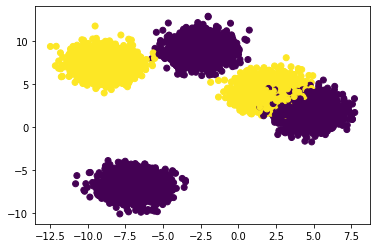

In [3]:
x, y = dataset_binary
plt.scatter(x[:, 0], x[:, 1], c=y)

# Reliability diagram

We will first train a classifier, and a calibrator on top of it. We will then visualise the reliability diagram.

## Binary (only the positive class)

In [4]:
x, y = dataset_binary
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
clf = GaussianNB()
clf.fit(x_train, y_train)

GaussianNB()

Text(0.5, 1.0, 'Predicted probabilities')

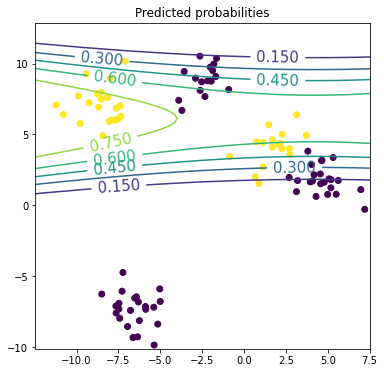

In [5]:
delta = 0.25
x0_grid = np.arange(x[:, 0].min(), x[:, 0].max(), delta)
x1_grid = np.arange(x[:, 1].min(), x[:, 1].max(), delta)
X0, X1 = np.meshgrid(x0_grid, x1_grid)
Y = clf.predict_proba(np.vstack((X0.flatten(), X1.flatten())).T)

fig, ax = plt.subplots(figsize=(6, 6))
CS = ax.contour(X0, X1, Y[:, 1].reshape(X0.shape))
ax.clabel(CS, inline=1, fontsize=15)
ax.scatter(x[:100, 0], x[:100, 1], c=y[:100])
ax.set_title('Predicted probabilities')

Text(0.5, 0, 'samples per bin')

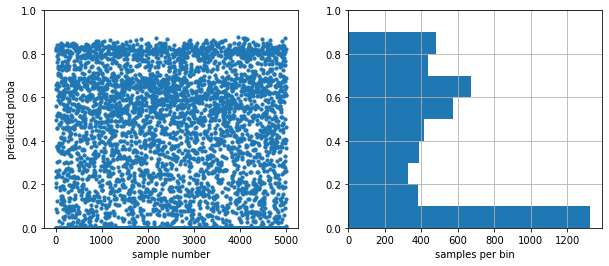

In [6]:
n_bins = 10
bins = np.linspace(0, 1, n_bins+1)

p_clf = clf.predict_proba(x_test)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.scatter(range(len(p_clf[:,1])), p_clf[:,1], s=10)
ax1.set_ylim(0, 1)
ax1.set_xlabel('sample number')
ax1.set_ylabel('predicted proba')
ax2.hist(p_clf[:, 1], bins=bins, orientation='horizontal')
ax2.set_ylim(0, 1)
ax2.grid()
ax2.set_xlabel('samples per bin')

/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  
/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Fraction of positives')

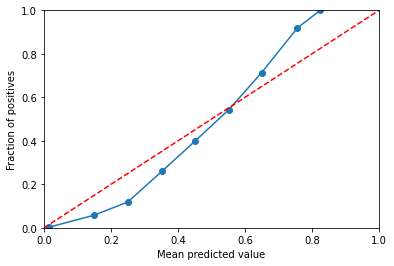

In [7]:
digitized = np.digitize(p_clf[:, 1], bins=bins)
pred_means = [p_clf[:, 1][digitized == i].mean() for i in range(1, n_bins+1)]
y_means = [y_test[digitized == i].mean() for i in range(1, n_bins+1)]

fig, ax = plt.subplots()
ax.plot(pred_means, y_means, 'o-')
ax.plot([0, 1], [0, 1], 'r--')
ax.set_xlim(0, 1)
ax.set_xlabel('Mean predicted value')
ax.set_ylim(0, 1)
ax.set_ylabel('Fraction of positives')

In [8]:
cal = CalibratedModel(clf, FullDirichletCalibrator())
cal.fit(x_train, y_train)

/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as 

CalibratedModel(base_estimator=GaussianNB(), method=FullDirichletCalibrator())

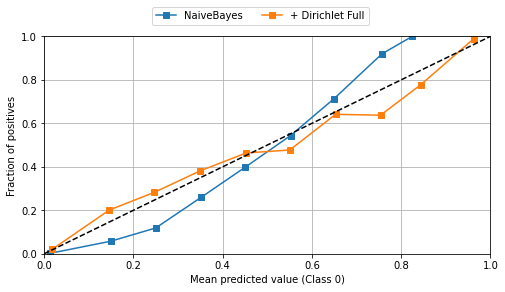

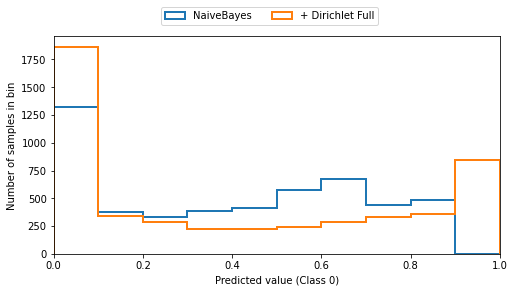

In [9]:
from pycalib.visualisations import plot_reliability_diagram

scores_list = [clf.predict_proba(x_test),
               cal.predict_proba(x_test)]

_ = plot_reliability_diagram(y_test, scores_list, legend=('NaiveBayes', '+ Dirichlet Full'), histogram=True)

## Multiclass (one per class)

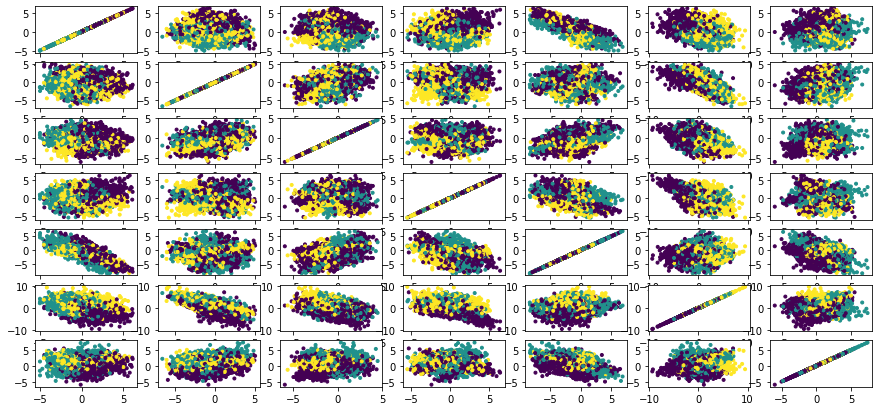

In [10]:
n_features = 7
dataset_ternary = make_classification(n_classes=3, n_samples=10000,
                                    n_clusters_per_class=3,
                                    n_features=n_features,
                                    n_informative=5,
                                    random_state=42)

x, y = dataset_ternary

fig = plt.figure(figsize=(15, 7))
for i in range(n_features):
    for j in range(n_features):
        ax = fig.add_subplot(n_features, n_features, 1 + i + j*n_features)
        plt.scatter(x[:,i], x[:,j], c=y, marker='.')

/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


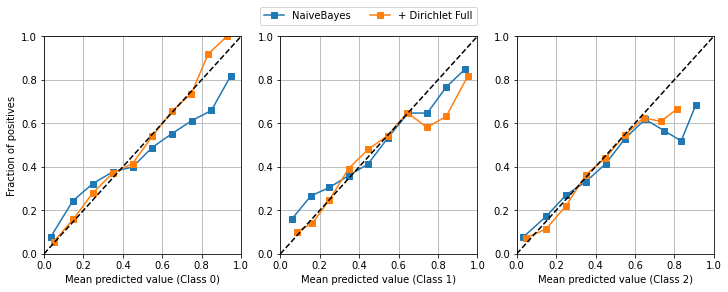

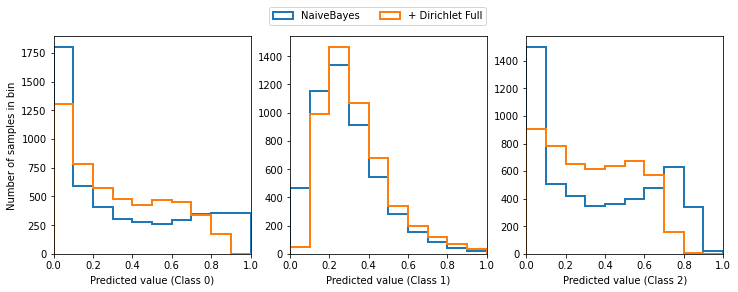

In [11]:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
clf = GaussianNB()
clf.fit(x_train, y_train)
cal = CalibratedModel(clf, FullDirichletCalibrator())
cal.fit(x_train, y_train)
scores_list = [clf.predict_proba(x_test),
          cal.predict_proba(x_test)]

_ = plot_reliability_diagram(y_test, scores_list, legend=('NaiveBayes', '+ Dirichlet Full'),
                             histogram=True)

# Reliability Diagram gaps

## Binary

/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


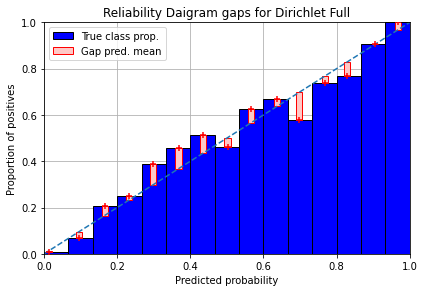

In [12]:
from pycalib.visualisations import plot_binary_reliability_diagram_gaps

x, y = dataset_binary
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
cal = CalibratedModel(GaussianNB(), FullDirichletCalibrator())
cal.fit(x_train, y_train)

est_scores = cal.predict_proba(x_test)
fig, ax = plot_binary_reliability_diagram_gaps(y_test, est_scores, n_bins=15)
_ = ax.set_title('Reliability Daigram gaps for Dirichlet Full')

## Multiclass

We can show only the confidence (only the highest predicted probability per sample)

/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


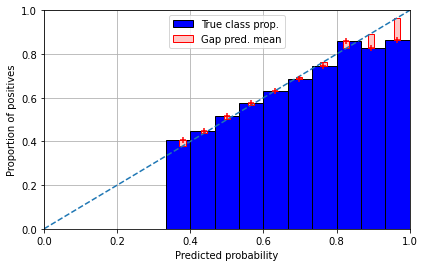

In [13]:
from pycalib.visualisations import plot_multiclass_reliability_diagram_gaps

from sklearn.preprocessing import OneHotEncoder

x, y = dataset_ternary
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
cal = CalibratedModel(GaussianNB(), FullDirichletCalibrator())
cal.fit(x_train, y_train)

probas = cal.predict_proba(x_test)
_ = plot_multiclass_reliability_diagram_gaps(y_test, probas, per_class=False)

Or all predicted probabilities per class

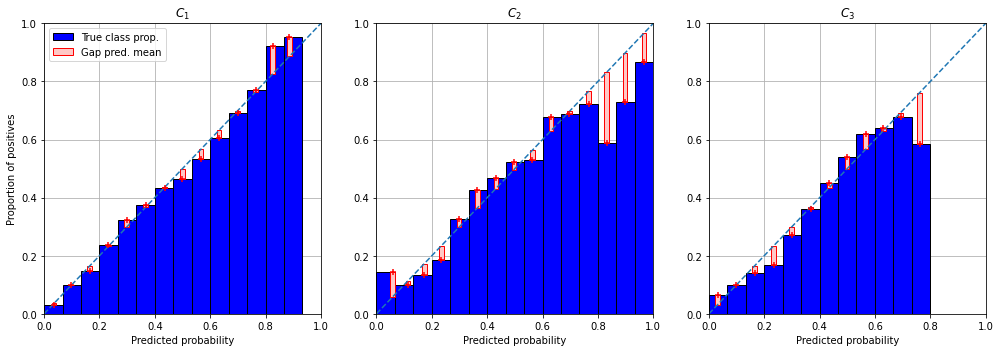

In [14]:
fig = plt.figure(figsize=(14, 5))
_ = plot_multiclass_reliability_diagram_gaps(y_test, probas, per_class=True, fig=fig)

# Calibration maps

These plots show the transformation that the calibrator is performing to the classifier scores. This is a C to C function where C is the number of classes. In the binary case it is comonly shown for the positive class

## Binary calibration maps

/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


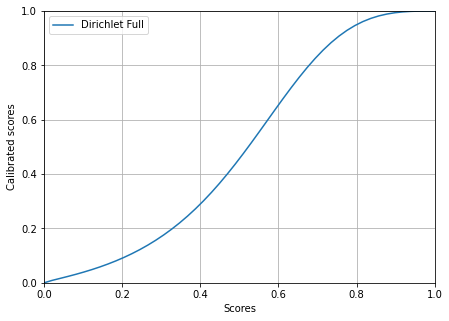

In [15]:
import matplotlib.pyplot as plt

x, y = dataset_binary
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
cal = CalibratedModel(GaussianNB(), FullDirichletCalibrator())
cal.fit(x_train, y_train)

scores_linspace = np.linspace(0, 1, 50)
scores_linspace = np.vstack((1-scores_linspace, scores_linspace)).T
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)
calibrated = cal.calibrator.predict_proba(scores_linspace)
ax.plot(scores_linspace[:, 1], calibrated[:, 1], label='Dirichlet Full')
ax.legend()
ax.set_xlabel('Scores')
ax.set_ylabel('Calibrated scores')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid()

## 2D slices of Ternary Calibration maps

/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/miquel/git/uob/classifier-calibration/hands_on/venv/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


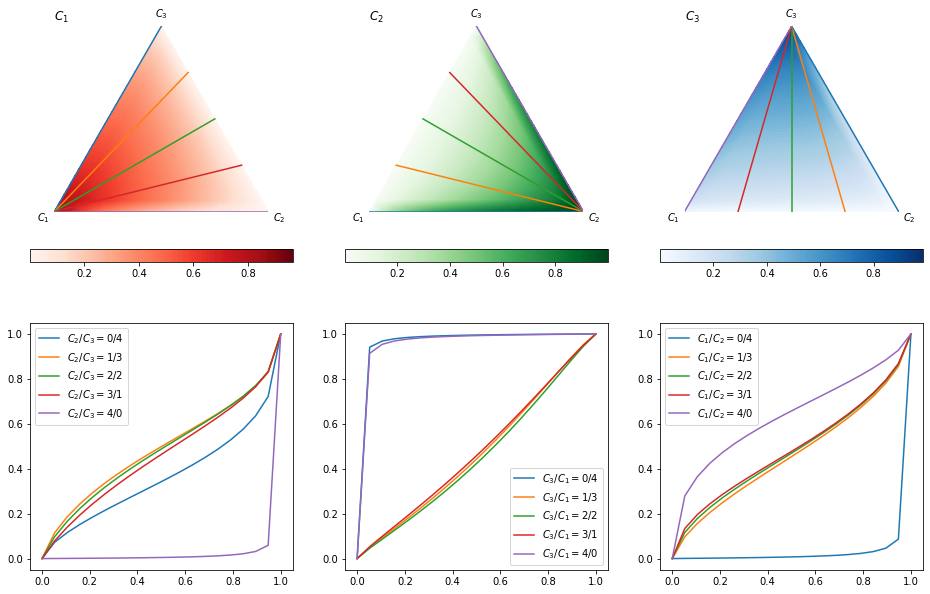

In [16]:
x, y = dataset_ternary
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)
cal = CalibratedModel(GaussianNB(), FullDirichletCalibrator())
cal.fit(x_train, y_train)

from pycalib.visualisations.ternary import draw_func_contours, plot_converging_lines_pvalues, get_converging_lines

c_mark = [{'color':[.5, 0, 0], 'marker':'.', 'label':r'$C_1$', 'cmap':'Reds'},
          {'color':[0, .5, 0], 'marker':'x', 'label':r'$C_2$', 'cmap':'Greens'},
          {'color':[0, 0, .5], 'marker':'+', 'label':r'$C_3$', 'cmap':'Blues'}]


fig = plt.figure(figsize=(16, 10))
for i, c in enumerate(['C1', 'C2', 'C3']):
    ax = fig.add_subplot(2, 3, i+1)

    ax.set_title('$C_{}$'.format(i+1), loc='left')

    function = lambda x: cal.calibrator.predict_proba(x.reshape(1,-1))[0][i]
    draw_func_contours(function, labels='auto', fig=fig, ax=ax, cmap=c_mark[i]['cmap'],
                       nlevels=100, subdiv=4, draw_lines=5, class_index=i)

    ax2 = fig.add_subplot(2, 3, 3+i+1)
    lines = get_converging_lines(num_lines=5, mesh_precision=20, class_index=i)
    plot_converging_lines_pvalues(function, lines, i, ax2)

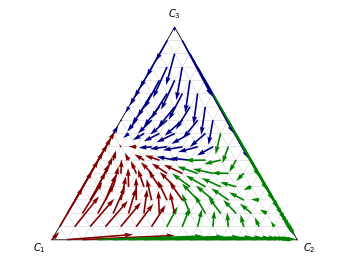

In [17]:
from pycalib.visualisations.barycentric import draw_calibration_map
from pycalib.visualisations.barycentric import get_mesh_bc
from pycalib.models import CalibratedModel

from dirichletcal import FullDirichletCalibrator, FixedDiagonalDirichletCalibrator, DirichletCalibrator

P_bc_grid = get_mesh_bc(subdiv=4)

calibrated = cal.calibrator.predict_proba(P_bc_grid)
color = [c_mark[i]['color'] for i in calibrated.argmax(axis=1).astype(int)]
_ = draw_calibration_map(P_bc_grid, calibrated, color=color,  subdiv=4)